基于Google Colab使用pytorch框架进行试验。    
导入相关包后，进入作业路径，并打印数据集路径下内容。如果没有该路径，或该路径下无数据，则需导入数据。

In [36]:
import os 
import sys 
import pandas as pd 
import numpy as np 
import csv

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from collections import Counter
from tqdm import tqdm


os.chdir("/content/drive/MyDrive/DL2021Spring")
os.listdir(os.path.join(os.path.abspath(""), "aclImdb"))

['imdb.vocab',
 'test',
 'imdbEr.txt',
 'README',
 'train',
 'train.csv',
 '.ipynb_checkpoints']

使用GPU。

In [37]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


在ppt给定下载地址down下数据集，并解压缩。

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxvf aclImdb_v1.tar.gz

--2021-06-14 10:15:05--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  25.6MB/s    in 3.1s    

2021-06-14 10:15:08 (25.6 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



csv格式比txt处理起来更高效一点，将数据集中的独立txt文档批量写入到csv。

In [20]:
def txt2csv(path):
  """
  @ Params:
  path: str, "train" or "test"
  """
  if not ( path == "train" or path == "test"):
    sys.stderr.write("invalid params input.")
    return -1
  posPath = os.path.join(os.path.abspath(""), "aclImdb", path, "pos")
  negPath = os.path.join(os.path.abspath(""), "aclImdb", path, "neg")
  csvPath = os.path.join(os.path.abspath(""), "aclImdb", path +".csv")
  posFiles = os.listdir(posPath)
  negFiles = os.listdir(negPath)
  # files = posFiles + negFiles
  # files.sort()
  with open(csvPath, "a+", newline='', encoding='utf-8') as csvFile:
    writer = csv.writer(csvFile, dialect='excel')
    for posFile in posFiles:
      with open(os.path.join(posPath, posFile), 'r') as pf:
        content = pf.readline()
        line = [content, 'positive']
        writer.writerow(line)
  
  with open(csvPath, "a+", newline='', encoding='utf-8') as csvFile:
    writer = csv.writer(csvFile, dialect='excel')
    for negFile in negFiles:
      with open(os.path.join(negPath, negFile), 'r') as nf:
        content = nf.readline()
        line = [content, 'negative']
        writer.writerow(line)


我们采取的是追加写入模式，由于此前已经生成了相应csv，这里就不去运行转换函数了。

In [ ]:
txt2csv("train")
txt2csv("test")

打印头尾，简单验证下写入的csv格式为第一列数据，第二列标签。    
有几个需要注意的地方：    
1. 写入`test.csv`的时候出现了一行多列（大于2）数据。便利检查字符子串，问题出现在`688_4.txt`文件，原因未知。处理方案是手动删去这一行。    
2. 验证性的实验，没有过多考虑异常情况。于是网络对数据的要求较为严格，必须每个batch为50条数据，但是生成的`test.csv`只有24998行。处理方法是手动复制了两行重复数据补齐到25000。     
3. 自己添加表头。


In [38]:
train_csv = pd.read_csv(os.path.join(os.path.abspath(""), "aclImdb", "train.csv"), header=None)
train_csv.columns = ["review", "sentiment"]
print(train_csv.head())
print(train_csv.shape)

test_csv = pd.read_csv(os.path.join(os.path.abspath(""), "aclImdb", "test.csv"), engine='python', header=None)
test_csv.columns = ["review", "sentiment"]
print(test_csv.tail())
print(test_csv.shape)



                                              review sentiment
0  Bromwell High is a cartoon comedy. It ran at t...  positive
1  Homelessness (or Houselessness as George Carli...  positive
2  Brilliant over-acting by Lesley Ann Warren. Be...  positive
3  This is easily the most underrated film inn th...  positive
4  This is not the typical Mel Brooks film. It wa...  positive
(25000, 2)
                                                  review sentiment
24995  I occasionally let my kids watch this garbage ...  negative
24996  When all we have anymore is pretty much realit...  negative
24997  The basic genre is a thriller intercut with an...  negative
24998  Four things intrigued me as to this film - fir...  negative
24999  David Bryce's comments nearby are exceptionall...  negative
(25000, 2)


从pandas读取格式数据里取出数据值。

In [39]:
x_train, y_train = train_csv["review"].values, train_csv["sentiment"].values
x_test, y_test = test_csv["review"].values, test_csv["sentiment"].values
print(y_test)

['positive' 'positive' 'positive' ... 'negative' 'negative' 'negative']


查看类分布情况。两类数据很简单，没有类不均衡，甚至非常均衡。

<function matplotlib.pyplot.show>

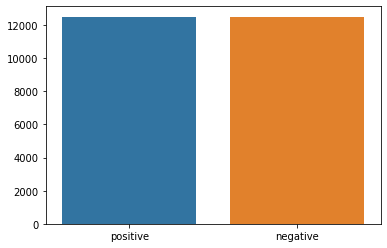

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(["positive", "negative"]), y=dd.values)
plt.show

分词，顺带去掉那些奇奇怪怪的字符，只留下英文字符。    
返回分词、筛选、one-hot化等操作处理后的数据。

In [41]:
import re
import string
from nltk.corpus import stopwords
from collections import Counter
import nltk
nltk.download("stopwords")

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


打印一下词典长度，不打印也没事儿。

In [43]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


对每条评论的长度（包含的单词数）进行统计分析顺便可视化。

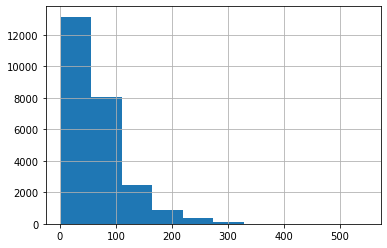

count    25000.000000
mean        69.913360
std         48.759665
min          2.000000
25%         39.000000
50%         55.000000
75%         85.000000
max        545.000000
dtype: float64

In [44]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

填充每条评论为500词。

In [45]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [46]:
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)


torch.utils.data.TensorLoader加载数据为Tensor格式。

In [47]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [48]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   5, 147,   3],
        [  0,   0,   0,  ..., 170,   4, 160],
        [  0,   0,   0,  ..., 357,  25,  81],
        ...,
        [  0,   0,   0,  ..., 182,   2,  42],
        [  0,   0,   0,  ..., 327,  59,  64],
        [  0,   0,   0,  ..., 201,  39, 180]])
Sample input: 
 tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1])


搭建LSTM模型。

In [49]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

网络超参数。

In [50]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


指定损失、优化、学习策略。

In [51]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

固定学习率跑10个epoch验证下。之前已经跑过5个epoch了，网络本身已经不错了，所以整体上升不太明显。

In [53]:
clip = 5
epochs = 10 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.2781439098417759 val_loss : 0.34429263062775134
train_accuracy : 88.376 val_accuracy : 84.89999999999999
Validation loss decreased (inf --> 0.344293).  Saving model ...
Epoch 2
train_loss : 0.24326414647698402 val_loss : 0.3482039065510035
train_accuracy : 89.992 val_accuracy : 85.396
Epoch 3
train_loss : 0.19033577992022038 val_loss : 0.44427646946907046
train_accuracy : 92.376 val_accuracy : 85.068
Epoch 4
train_loss : 0.12702367993816732 val_loss : 0.5122180151194334
train_accuracy : 95.148 val_accuracy : 84.832
Epoch 5
train_loss : 0.07448619556427002 val_loss : 0.5959768433272838
train_accuracy : 97.344 val_accuracy : 83.464
Epoch 6
train_loss : 0.046698180798674 val_loss : 0.7310091669559479
train_accuracy : 98.36399999999999 val_accuracy : 83.872
Epoch 7
train_loss : 0.03407603194162948 val_loss : 0.7811341223120689
train_accuracy : 98.804 val_accuracy : 83.748
Epoch 8
train_loss : 0.025819237804040312 val_loss : 0.8442422247976065
train_accuracy : 99.176 

绘制准确率和损失折线。

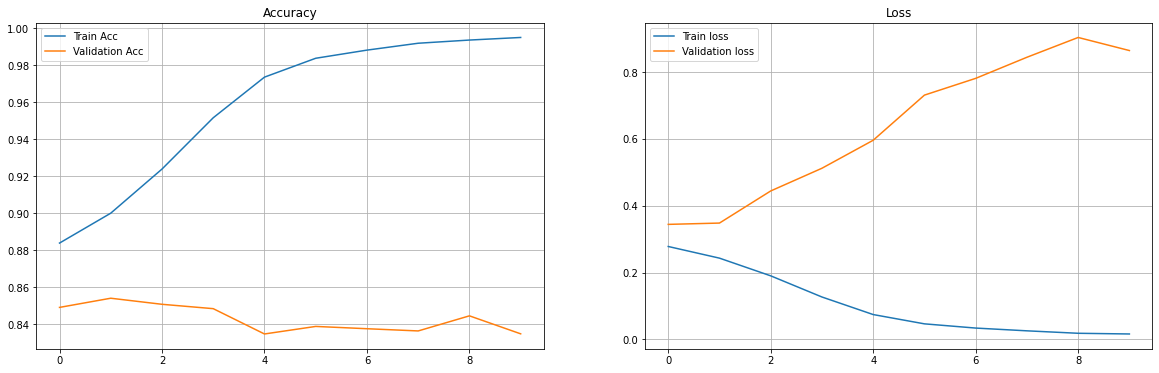

In [54]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

inference一下试试。

In [55]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

行，效果挺好。

In [60]:

index = 30
print(test_csv['review'][index])
print('='*70)
print(f'Actual sentiment is  : {test_csv["sentiment"][index]}')
print('='*70)
pro = predict_text(test_csv['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

If you keep rigid historical perspective out of it, this film is actually quite entertaining. It's got action, adventure and romance, and one of the premiere casting match-ups of the era with Errol Flynn and Olivia de Havilland in the lead roles. As evident on this board, the picture doesn't pass muster with purists who look for one hundred percent accuracy in their story telling. To get beyond that, one need only put aside the history book, and enjoy the story as if it were a work of fiction. I know, I know, that's hard to do when you consider Custer's Last Stand at the Little Big Horn and it's prominence in the history of post Civil War America. So I guess there's an unresolved quandary with the picture, no matter how you look at it.<br /><br />There's a lot to take in here though for the picture's two hour plus run time. Custer's arrival at West Point is probably the first head scratcher, riding up as he does in full military regalia. The practical joke by Sharp (Arthur Kennedy) put

In [61]:

index = 300
print(test_csv['review'][index])
print('='*70)
print(f'Actual sentiment is  : {test_csv["sentiment"][index]}')
print('='*70)
pro = predict_text(test_csv['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

This is a great comedy, highlighting what it was like to live next door to racist bigot. But also shows that both main characters are actually as bad as each other. Based on the hit ITV comedy, this is very politically incorrect. And its all the better for it, comedy after all is to entertain. The movies only real drawback is there isnt much of a plot. However the cast are as great as usual. Jack Smethurst and Rudolph Walker make one hell of a team, playing off each other in a oneupmanship kind of way.It's been many years since i saw this movie and last week was finally able to buy it on dvd. The fact that the movie still contains genuine laugh out loud moments, means that i can recommend this movie, just like i would of back in the 1970's.
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.5756922960281372
